# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [145]:
#Import all the required libraries
import os, glob
from glob import glob
import pickle
from sys import getsizeof

import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Layer, Dense, Embedding, GRU
from tensorflow.nn import relu, tanh, softmax

import matplotlib.pyplot as plt

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [146]:
#Import the dataset and read the image into a seperate variable

images= "/kaggle/input/flickr8k/Images"

all_imgs = glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [147]:
all_imgs[0]

'/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg'

In [148]:
# function to plot n images using subplots
def plotImage(images, captions, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        img = image[image.rfind("/")+1:]
        cap = captions[captions['image'] == img].iloc[:1,1].values[0] # get the first caption
        
        ax.set_title(cap)
        ax.imshow(io.imread(image), cmap)

In [149]:
#Visualise both the images & text present in the dataset
captions = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


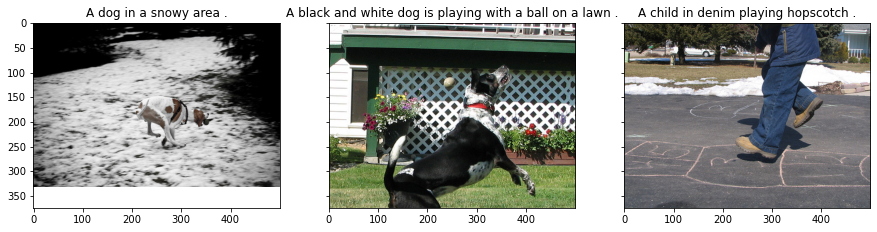

In [150]:
plotImage(all_imgs[0:3], captions)

In [151]:
#Import the dataset and read the text file into a seperate variable

# def load_doc(filename):
    
#     #your code here
    
#     return text

# doc = load_doc(text_file)
# print(doc[:300])

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [152]:
df = captions.copy()
df.columns = ['ID','Captions']

df['Path'] = images + "/" + df['ID']

all_img_id= df['ID']
all_img_vector= df['Path']
annotations= df['Captions']

df

,ID,Captions,Path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/kaggle/input/flickr8k/Images/1000268201_693b0...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/kaggle/input/flickr8k/Images/1000268201_693b0...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/kaggle/input/flickr8k/Images/1000268201_693b0...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/kaggle/input/flickr8k/Images/1000268201_693b0...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/kaggle/input/flickr8k/Images/1000268201_693b0...
...,...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,/kaggle/input/flickr8k/Images/997722733_0cb543...
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,/kaggle/input/flickr8k/Images/997722733_0cb543...
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,/kaggle/input/flickr8k/Images/997722733_0cb543...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,/kaggle/input/flickr8k/Images/997722733_0cb543...


In [153]:
def get_vocab(captions):
    vocabs = map(lambda caption: re.split("\W+", caption.lower()), captions)
    return (word for vocab in vocabs for word in vocab if word != "")

In [154]:
#Create the vocabulary & the counter for the captions

vocabulary= list(get_vocab(df.Captions))

val_count=Counter(vocabulary)
print(val_count['a'])
print(val_count['start'])

62992
9


In [155]:
#convert to dataframe
vocabs = pd.DataFrame.from_dict(val_count, orient='index').reset_index()
vocabs.columns = ['word','count']
vocabs = vocabs.sort_values(by='count', ascending=False)
vocabs.head()

,word,count
0,a,62992
2,in,18986
21,the,18419
37,on,10745
5,is,9345


Text(0, 0.5, 'Count')

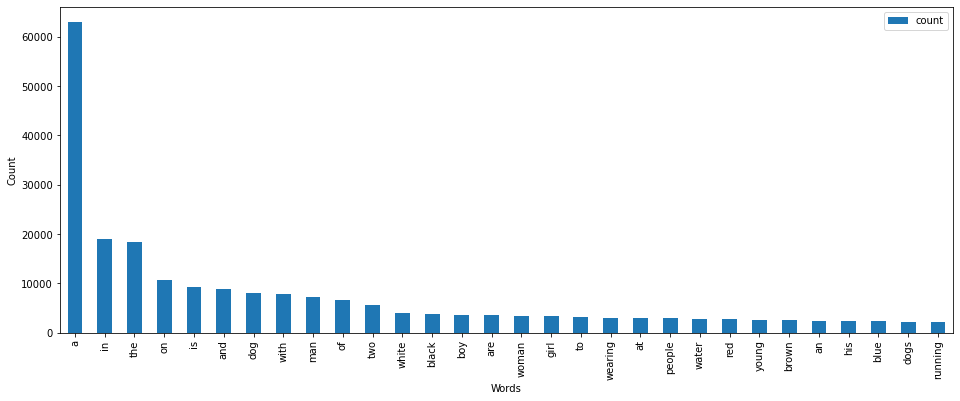

In [156]:
#Visualise the top 30 occuring words in the captions
plt.rcParams["figure.figsize"] = [16, 6]

vocabs.head(30).plot(kind='bar', x='word', y='count')

plt.xlabel("Words")
plt.ylabel("Count")

In [157]:
#Create a list which contains all the captions
df['Captions'] = "<start> " + df['Captions'] + " <end>"
annotations = df['Captions']

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path= list(df['Path'])

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [158]:
df.head()

,ID,Captions,Path
0,1000268201_693b08cb0e.jpg,<start> A child in a pink dress is climbing up...,/kaggle/input/flickr8k/Images/1000268201_693b0...
1,1000268201_693b08cb0e.jpg,<start> A girl going into a wooden building . ...,/kaggle/input/flickr8k/Images/1000268201_693b0...
2,1000268201_693b08cb0e.jpg,<start> A little girl climbing into a wooden p...,/kaggle/input/flickr8k/Images/1000268201_693b0...
3,1000268201_693b08cb0e.jpg,<start> A little girl climbing the stairs to h...,/kaggle/input/flickr8k/Images/1000268201_693b0...
4,1000268201_693b08cb0e.jpg,<start> A little girl in a pink dress going in...,/kaggle/input/flickr8k/Images/1000268201_693b0...


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [159]:
# create the tokenizer
def tokenize(captions):
    special_chars = '`~"@#$%&()[]{}!*+=.,/:;?\^-_| '
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000,
                                                  oov_token="UNK",
                                                  filters=special_chars)
    tokenizer.fit_on_texts(captions)   
   
    return tokenizer 


img_captions, img_name_vector = shuffle(annotations, all_img_vector, random_state=42)
tokenizer = tokenize(img_captions)

In [160]:
# Create word-to-index and index-to-word mapping

def word_2_index(word):
    return tokenizer.word_index[word]
    
def index_2_word(index):
    return tokenizer.index_word[index]

print(index_2_word(10))
print(word_2_index('dog'))

dog
10


Text(0, 0.5, 'Count')

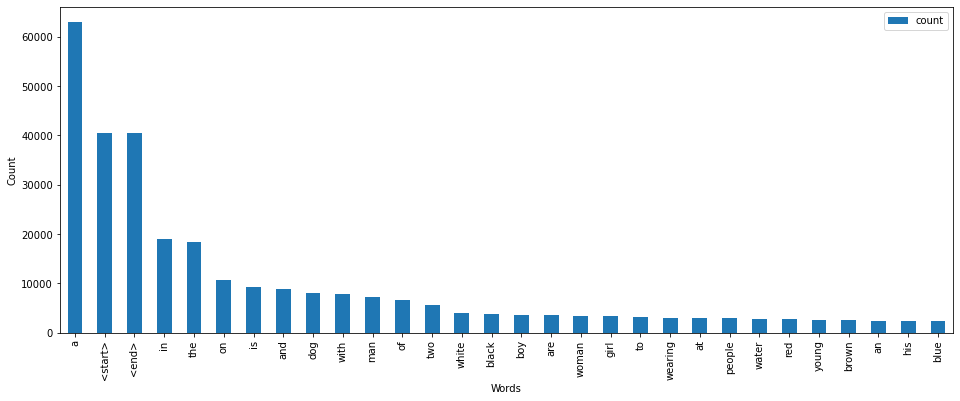

In [161]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

import operator
plt.rcParams["figure.figsize"] = [16, 6]

words = sorted(tokenizer.word_counts.items(), key=operator.itemgetter(1),reverse=True)
vocabs = pd.DataFrame(words)
vocabs.columns = ['word','count']
vocabs.head(30).plot(kind='bar', x='word', y='count')

plt.xlabel("Words")
plt.ylabel("Count")

In [162]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

caption_sequences = tokenizer.texts_to_sequences(img_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(caption_sequences, padding='post')

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [163]:
def preprocess_the_image(imagePath):
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, imagePath

allImages = sorted(set(img_name_vector))

train_dataset = tf.data.Dataset.from_tensor_slices(allImages)
train_dataset = train_dataset.map(preprocess_the_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [164]:
image_train, image_test, captions_train, captions_test = train_test_split(img_name_vector,
                                                                          cap_vector, 
                                                                          test_size=0.2, 
                                                                          random_state=42)

In [165]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


In [166]:
img_to_cap_vector = collections.defaultdict(list)

for img,cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

In [167]:
def vector_to_sentence(caplist):
    captions_word =[]
    for captions in caplist:
        list_caption = list(captions)

        captions_word.append(' '.join(tokenizer.index_word[i] for i in list_caption))
    return captions_word

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [168]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [169]:
from tqdm import tqdm

all_features_dict = {}
for img,path in tqdm(train_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        file_name = p.numpy().decode("utf-8")
        all_features_dict[file_name] = bf.numpy()

100%|██████████| 127/127 [00:45<00:00,  2.79it/s]


In [170]:
# write your code to extract features from each image in the dataset

def feature_tensor(img_name, cap):
    img_tensor = all_features_dict[img_name.decode("utf-8")]
    return img_tensor, cap

BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_dataset = tf.data.Dataset.from_tensor_slices((image_train, captions_train))

train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
                                   feature_tensor, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.data.Dataset.from_tensor_slices((image_test, captions_test))

test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          feature_tensor, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [171]:
train_img_batch, train_cap_batch = next(iter(train_dataset))
print(train_img_batch.shape)
print(train_cap_batch.shape)

(64, 64, 2048)
(64, 39)


In [172]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [173]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE 
test_num_steps = len(image_test) // BATCH_SIZE

### Encoder

In [174]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = Dense(embed_dim)
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = relu(features)
        
        return features

In [175]:
encoder=Encoder(embedding_dim)

### Attention model

In [176]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = Dense(units) #build your Dense layer
        self.W2 = Dense(units) #build your Dense layer
        self.V = Dense(1) #build your final Dense layer with unit 1
        self.units = units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V(tanh(self.W1(features) + self.W2(hidden_with_time_axis))) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = softmax(score, axis = 1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis = 1) # reduce the shape to (batch_size, embedding_dim)

        return context_vector, attention_weights

### Decoder

In [177]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = Embedding(vocab_size,embed_dim) #build your Embedding layer
        self.gru = GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = Dense(self.units) #build your Dense layer
        self.d2 = Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector,1),embed],axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [178]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [179]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [180]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True, reduction='none') #define your loss object
metrics = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [181]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [182]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [183]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [184]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor,training =True)

        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    metrics(loss)    
        
    return loss, total_loss

In [185]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)
            predicted_id = tf.argmax(predictions[0])
            dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)
   
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [186]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss

    avg_test_loss = total_loss/int(target.shape[1])
    
    return avg_test_loss

In [187]:
import datetime,time

loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    avg_train_loss = total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.282, & test loss is 6.109
Time taken for 1 epoch 206.21386909484863 sec

Test loss has been reduced from 100.000 to 6.109


 13%|█▎        | 2/15 [04:55<29:44, 137.30s/it]

For epoch: 2, the train loss is 0.997, & test loss is 6.119
Time taken for 1 epoch 88.90891027450562 sec



 20%|██        | 3/15 [06:23<22:58, 114.90s/it]

For epoch: 3, the train loss is 0.907, & test loss is 6.545
Time taken for 1 epoch 88.22988367080688 sec



 27%|██▋       | 4/15 [07:52<19:09, 104.53s/it]

For epoch: 4, the train loss is 0.844, & test loss is 6.184
Time taken for 1 epoch 88.63967418670654 sec



 33%|███▎      | 5/15 [09:20<16:26, 98.61s/it] 

For epoch: 5, the train loss is 0.793, & test loss is 6.476
Time taken for 1 epoch 88.1185257434845 sec



 40%|████      | 6/15 [10:48<14:16, 95.15s/it]

For epoch: 6, the train loss is 0.750, & test loss is 6.435
Time taken for 1 epoch 88.43790340423584 sec



 47%|████▋     | 7/15 [12:17<12:23, 92.92s/it]

For epoch: 7, the train loss is 0.709, & test loss is 6.459
Time taken for 1 epoch 88.31014132499695 sec



 53%|█████▎    | 8/15 [13:46<10:41, 91.65s/it]

For epoch: 8, the train loss is 0.672, & test loss is 6.471
Time taken for 1 epoch 88.9488410949707 sec



 60%|██████    | 9/15 [15:15<09:05, 90.95s/it]

For epoch: 9, the train loss is 0.638, & test loss is 6.722
Time taken for 1 epoch 89.39171814918518 sec



 67%|██████▋   | 10/15 [16:43<07:30, 90.01s/it]

For epoch: 10, the train loss is 0.604, & test loss is 6.990
Time taken for 1 epoch 87.90751838684082 sec



 73%|███████▎  | 11/15 [18:11<05:58, 89.55s/it]

For epoch: 11, the train loss is 0.574, & test loss is 7.069
Time taken for 1 epoch 88.50107836723328 sec



 80%|████████  | 12/15 [19:40<04:27, 89.27s/it]

For epoch: 12, the train loss is 0.544, & test loss is 7.286
Time taken for 1 epoch 88.64131736755371 sec



 87%|████████▋ | 13/15 [21:09<02:58, 89.06s/it]

For epoch: 13, the train loss is 0.518, & test loss is 7.473
Time taken for 1 epoch 88.56332039833069 sec



 93%|█████████▎| 14/15 [22:37<01:28, 88.77s/it]

For epoch: 14, the train loss is 0.492, & test loss is 7.755
Time taken for 1 epoch 88.09603905677795 sec



100%|██████████| 15/15 [24:05<00:00, 96.38s/it]

For epoch: 15, the train loss is 0.468, & test loss is 7.991
Time taken for 1 epoch 88.5954692363739 sec



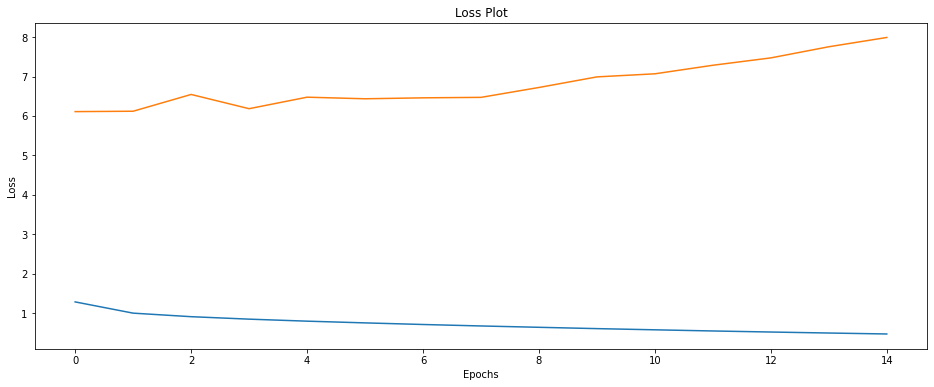

In [188]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [189]:
def evaluate(image):
    max_length = cap_vector.shape[1]
    attention_features_shape = 64
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)
    
    pimg, path = preprocess_the_image(image)

    temp_input = tf.expand_dims(pimg, 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden) # get the output from decoder
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


### Beam Search(optional)

In [190]:
# def beam_evaluate(image, beam_index = #your value for beam index):

#     #write your code to evaluate the result using beam search
                  
#     return final_caption



In [191]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [192]:
from nltk.translate.bleu_score import sentence_bleu

In [193]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 35.826565528689464
Real Caption: a black dog is digging in the snow.
Prediction Caption: a dog is digging in snow


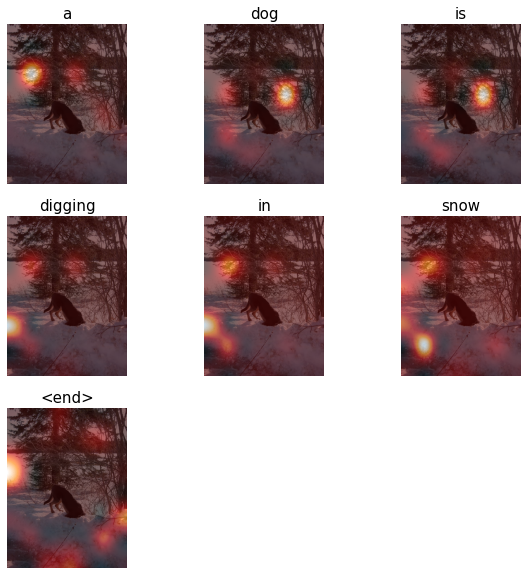

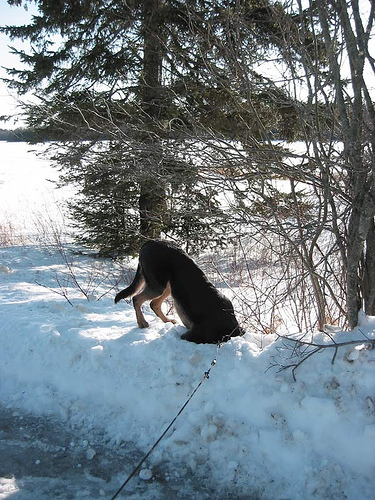

In [194]:
rid = np.random.randint(0, len(image_test))
#test_image = df['Path'][rid]
test_image = '/kaggle/input/flickr8k/Images/413231421_43833a11f5.jpg'
real_caption = '<start> a black dog is digging in the snow. <end>'

#real_caption = ' '.join([tokenizer.index_word[i] for i in captions_test[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0,0,1,0))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [195]:
# skipping the optional one
# captions=beam_evaluate(test_image)
# print(captions)